## Embedding Analysis Overview

This notebook explores various techniques for analyzing textual data through word embeddings. The key components include:

- **Word2Vec**: To generate vector representations of words based on their context.
- **t-SNE**: For dimensionality reduction and visualization of high-dimensional embeddings in 2D space.
- **Cosine Similarity**: To measure the semantic similarity between `context`, `question`, and `answer` fields.
- **K-Means Clustering**: To group semantically similar text samples based on their embeddings.

The goal is to understand semantic patterns in the dataset by embedding, comparing, and clustering natural language components.

## 1. Load the Dataset and Perform Exploratory Data Analysis (EDA)

We begin by loading the dataset, which contains natural language fields such as `context`, `question`, and `answer`.  
Basic exploratory data analysis (EDA) is performed to understand the structure, size, and content of the data.  
This includes checking column names, missing values, and a preview of sample entries.

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
splits = {'train': 'data/train-00000-of-00001-9df3a936e1f63191.parquet', 'test': 'data/test-00000-of-00001-af2a9f454ad1b8a3.parquet'}
df = pd.read_parquet("hf://datasets/neural-bridge/rag-dataset-12000/" + splits["train"])

In [4]:
df.shape

(9600, 3)

In [5]:
df.columns

Index(['context', 'question', 'answer'], dtype='object')

"The RAG dataset 12 000" contains 9600 samples of context question and answer

## 2. Data Preprocessing

To prepare the text data for embedding, we apply several preprocessing steps:

- **Email and URL removal**: Strip out any email addresses and hyperlinks using regular expressions.
- **Punctuation removal**: Clean text from punctuation symbols.
- **Lowercasing**: Standardize all text to lowercase for consistency.
- **Tokenization**: Split text into individual words using NLTK's `RegexpTokenizer`.
- **Stopword removal**: Eliminate common English stopwords (e.g., "the", "and", "is") using NLTK.
- **Missing value removal**: Drop rows that contain missing (`NaN`) entries to ensure data integrity.

These transformations are applied to the `context`, `question`, and `answer` fields of the dataset.


In [6]:
def remove_emails_urls(text):
    if isinstance(text, str):
        text = re.sub(r"\b[\w.-]+@[\w.-]+\.\w+\b", "", text)         # emails
        text = re.sub(r"http\S+|www\.\S+", "", text)                # urls
    return text

In [7]:
df = df.applymap(remove_emails_urls)

C:\Users\User\AppData\Local\Temp\ipykernel_12180\1707929082.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(remove_emails_urls)


In [ ]:
df = df.applymap(lambda x: re.sub(r"[^\w\s@]", " ", x) if isinstance(x, str) else x)
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df = df.applymap(lambda x: re.sub(r"\n", " ", x) if isinstance(x, str) else x)

C:\Users\User\AppData\Local\Temp\ipykernel_12180\1710537768.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: re.sub(r"[^\w\s@]", " ", x) if isinstance(x, str) else x)
C:\Users\User\AppData\Local\Temp\ipykernel_12180\1710537768.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
C:\Users\User\AppData\Local\Temp\ipykernel_12180\1710537768.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: re.sub(r"\n", " ", x) if isinstance(x, str) else x)


In [12]:
df.dropna(subset=["question", "answer"], inplace=True)

In [13]:
df.shape

(9598, 3)

After dropping rows with missing values, the dataset now contains **9,598** rows and **3** columns.

In [19]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
df_1 = df.applymap(lambda x: tokenizer.tokenize(x.lower()) if isinstance(x, str) else x)

C:\Users\User\AppData\Local\Temp\ipykernel_12180\4187045613.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_1 = df.applymap(lambda x: tokenizer.tokenize(x.lower()) if isinstance(x, str) else x)


The default set of English stopwords from `nltk` does not include some common **auxiliary** and **modal verbs**, which may reduce noise when removed.  
To enhance the stopword filtering step, we extend the stopword list with a custom set:

```python
custom_words = {'would', 'could', 'should', 'shall', 'may', 'might', 'must', 'also'}

In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
custom_words = {'would', 'could', 'should', 'shall', 'may', 'might', 'must', 'also'}

# Add them to stopwords set
stop_words.update(custom_words)
df_1 = df_1.applymap(lambda x: [word for word in x if word not in stop_words])

C:\Users\User\AppData\Local\Temp\ipykernel_12180\3889552032.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_1 = df_1.applymap(lambda x: [word for word in x if word not in stop_words])


In [47]:
df_1 = df_1.applymap(lambda x: [word for word in x if not re.search(r'\d', word)] if isinstance(x, list) else x)

C:\Users\User\AppData\Local\Temp\ipykernel_12180\2948061708.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_1 = df_1.applymap(lambda x: [word for word in x if not re.search(r'\d', word)] if isinstance(x, list) else x)


In [52]:
number_words = {
    'zero', 'one', 'two', 'three', 'four', 'five',
    'six', 'seven', 'eight', 'nine', 'ten',
    'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen',
    'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty',
    'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety',
    'hundred', 'thousand', 'million', 'billion', 'trillion'
}

In the exploratory analysis, **number words** (e.g., "one", "two", "hundred", "thousand") were found to be among the top 10 most frequent tokens in the corpus.

Since these tokens are semantically weak and may introduce **distributional bias** into the embedding space, we explicitly remove them during preprocessing.

```python
number_words = {
    'zero', 'one', 'two', 'three', 'four', 'five',
    'six', 'seven', 'eight', 'nine', 'ten',
    'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen',
    'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty',
    'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety',
    'hundred', 'thousand', 'million', 'billion', 'trillion'
}

In [53]:
df_1 = df_1.applymap(lambda x: [word for word in x if word.lower() not in number_words] if isinstance(x, list) else x)

C:\Users\User\AppData\Local\Temp\ipykernel_12180\245220940.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_1 = df_1.applymap(lambda x: [word for word in x if word.lower() not in number_words] if isinstance(x, list) else x)


In [130]:
from itertools  import chain
flat_corpus = list(chain.from_iterable(corpus))
from nltk import FreqDist
# Create frequency distribution
fdist = FreqDist(flat_corpus)  

In [131]:
# Get most common words
print("Most common words:")
for word, count in fdist.most_common(10):
    print(f"{word}: {count}")

Most common words:
time: 11385
new: 11031
like: 10683
get: 9227
people: 8301
said: 7923
first: 7664
make: 7249
year: 6940
well: 6638


The top 10 most frequent words in the corpus include polysemous terms like **"like"** and **"well"**, which can function as verbs, adverbs, or adjectives depending on the context.

This ambiguity highlights a limitation of traditional Word2Vec, which generates a single embedding per word regardless of context.

To address this, one potential improvement is to use **Part-of-Speech (POS) tagging** to disambiguate word roles before embedding. For example, we can use `nltk.pos_tag` to annotate each token, enabling the model to learn distinct embeddings for, say, "like_VB" (verb) and "like_IN" (preposition).

We plan to compare the performance of:
- Standard Word2Vec (context-independent)
- Word2Vec trained on POS-tagged data (context-aware)

This will help evaluate whether syntactic context improves embedding quality.

In [132]:
from collections import Counter
from itertools import chain

tokens = list(chain.from_iterable(df_1['context'].tolist()))
Counter(tokens).most_common(10)

[('time', 10823),
 ('like', 10169),
 ('new', 9893),
 ('get', 8956),
 ('said', 7878),
 ('people', 7767),
 ('first', 6972),
 ('make', 6829),
 ('year', 6465),
 ('well', 6417)]

In [133]:
from collections import Counter
from itertools import chain

tokens = list(chain.from_iterable(df_tagged['context'].tolist()))
Counter(tokens).most_common(10)

[('time_NN', 10823),
 ('like_IN', 10024),
 ('new_JJ', 9893),
 ('said_VBD', 7878),
 ('people_NNS', 7767),
 ('year_NN', 6465),
 ('us_PRP', 6300),
 ('well_RB', 6242),
 ('good_JJ', 5908),
 ('many_JJ', 5641)]

Here we see that as predicted top 10 words were changed.

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [ ]:
from nltk import pos_tag
def tag_tokens(tokens):
    if isinstance(tokens, list):
        return [f"{word}_{tag}" for word, tag in pos_tag(tokens)]
    return tokens

In [125]:
df_tagged = df_1.applymap(tag_tokens)

C:\Users\User\AppData\Local\Temp\ipykernel_12180\776080613.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_tagged = df_1.applymap(tag_tokens)


In [129]:
corpus = df_1.context.dropna().tolist() + df_1.question.dropna().tolist() + df_1.answer.dropna().tolist()

In [128]:
corpus_tagged = df_tagged.context.dropna().tolist() + df_tagged.question.dropna().tolist() + df_tagged.answer.dropna().tolist()

These two sets will be used for further analysis:
 - corpus
 - corpus_tagged

## 3. Word2Vec Embedding

To capture the semantic meaning of words in the corpus, we train a **Word2Vec** model using the preprocessed tokens.

Word2Vec learns dense vector representations for words by leveraging their co-occurrence patterns in a context window.  
We use the **Skip-gram** architecture, which predicts surrounding context words from a target word. This is particularly effective for capturing relationships involving rare words.

### Model Configuration:
- `vector_size = 100`: Dimensionality of the word vectors
- `window = 5`: Maximum distance between the current and predicted word within a sentence
- `min_count = 2`: Ignores all words with total frequency lower than this
- `sg = 1`: Use the Skip-gram model (if set to 0, uses CBOW)
- `workers = 4`: Number of threads used for training


The resulting embeddings will later be used for similarity analysis and clustering tasks.


In [134]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count = 2, workers = 4, sg=1)

In [135]:
model.save('word2vec_sg1_v3.model')

In [137]:
model_tagged = Word2Vec(sentences=corpus_tagged, vector_size=100, window=5, min_count = 2, workers = 4, sg=1)

In [138]:
model_tagged.save('word2vec_sg1_tagged_v1.model')

## 4. Embedding Analysis using t-SNE Visualization

We apply t-SNE to a subset of the learned word embeddings and plot them to visually explore the semantic structure.


In [141]:
model = Word2Vec.load('word2vec_sg1_v3.model')

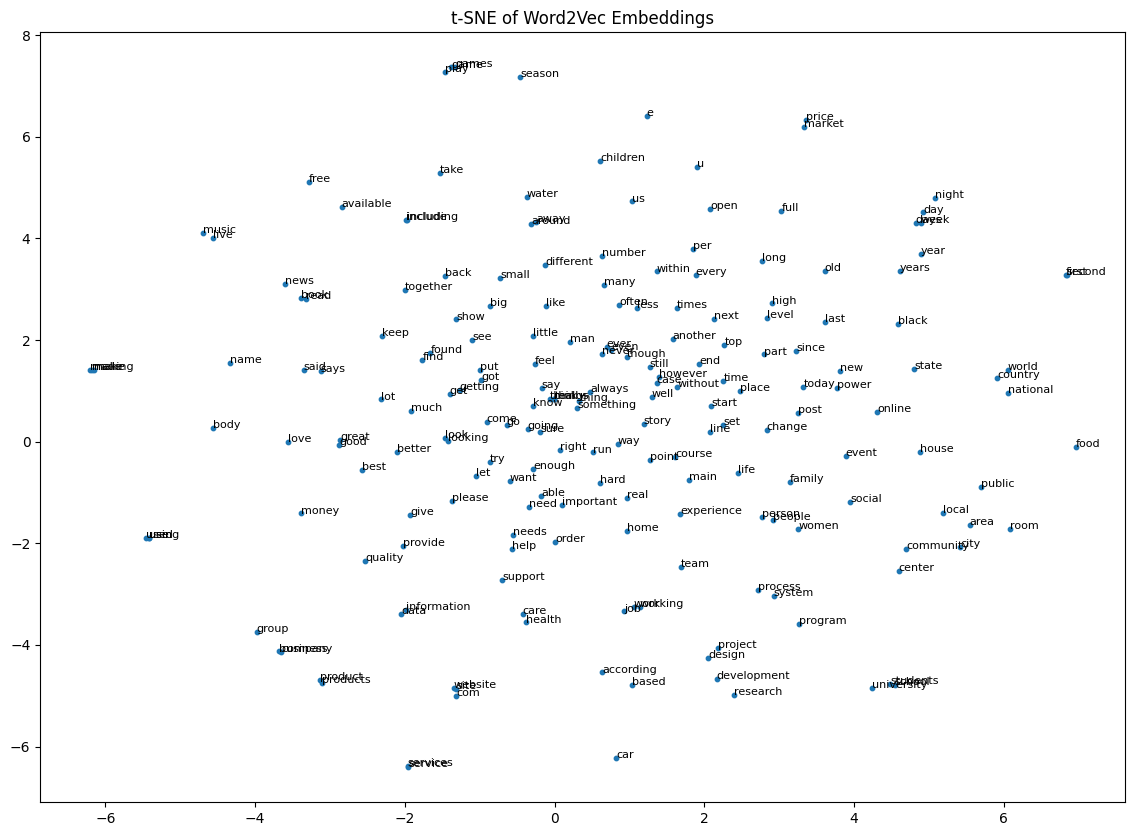

In [143]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

words = list(model.wv.index_to_key[:200])  # top 300 words
X = model.wv[words]
X_emb = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(14, 10))
plt.scatter(X_emb[:, 0], X_emb[:, 1], s=10)
for i, word in enumerate(words):
    plt.text(X_emb[i, 0], X_emb[i, 1], word, fontsize=8)
plt.title("t-SNE of Word2Vec Embeddings")
plt.show()

In [ ]:
model.wv.similarity('export', 'trade')

0.60798717

In [146]:
model.wv.most_similar('regulation')

[('mandates', 0.8310936689376831),
 ('mandated', 0.8298096060752869),
 ('stricter', 0.8283527493476868),
 ('regulators', 0.8209963440895081),
 ('conformity', 0.8163638710975647),
 ('antitrust', 0.8111076951026917),
 ('indirect', 0.7950779795646667),
 ('violating', 0.789936900138855),
 ('governed', 0.7881536483764648),
 ('statutory', 0.7880648970603943)]

In [147]:
model.wv.doesnt_match(['banana', 'apple', 'grape', 'truck'])

'truck'

Model has properly learning semantic relations between words like **"regulation"**, **"mandates"**, and **"statutory"**  which appear closely clustered in vector space. Also, it correctly detected the word **"truck"** that is not fruit.

In [166]:
model_tagged = Word2Vec.load('word2vec_sg1_tagged_v1.model')

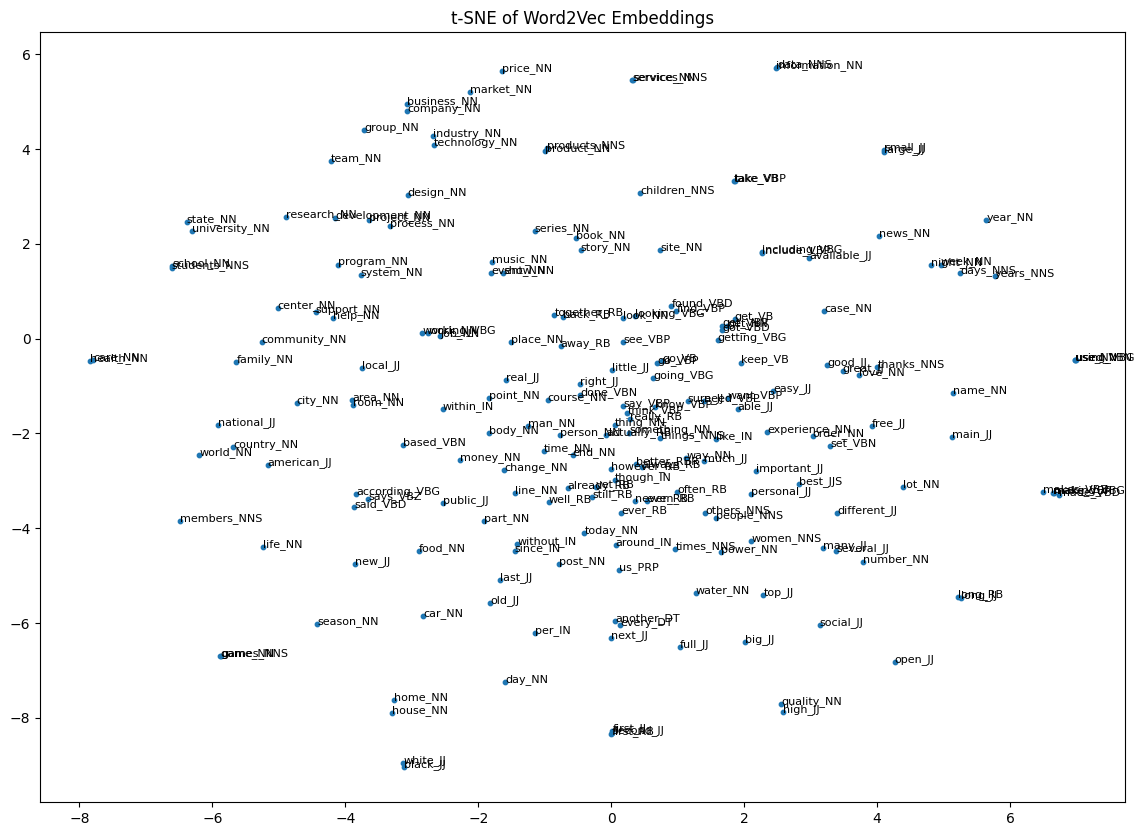

In [167]:
words = list(model_tagged.wv.index_to_key[:200])  # top 300 words
X = model_tagged.wv[words]
X_emb = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(14, 10))
plt.scatter(X_emb[:, 0], X_emb[:, 1], s=10)
for i, word in enumerate(words):
    plt.text(X_emb[i, 0], X_emb[i, 1], word, fontsize=8)
plt.title("t-SNE of Word2Vec Embeddings")
plt.show()

After applying POS tagging and training Word2Vec on the tagged data, we visualized the embeddings using t-SNE.

We observed that:
- **Most frequent words are nouns**, which are broadly dispersed across the embedding space.
- **Verbs tend to cluster** in a distinct region (notably overlapping on the right side of the plot).

In [169]:
model_tagged.wv.similarity('export_NN', 'trade_NN')

0.65609473

In [171]:
model.wv.most_similar('regulation')

[('mandates', 0.8310936689376831),
 ('mandated', 0.8298096060752869),
 ('stricter', 0.8283527493476868),
 ('regulators', 0.8209963440895081),
 ('conformity', 0.8163638710975647),
 ('antitrust', 0.8111076951026917),
 ('indirect', 0.7950779795646667),
 ('violating', 0.789936900138855),
 ('governed', 0.7881536483764648),
 ('statutory', 0.7880648970603943)]

In [173]:
model_tagged.wv.most_similar('regulation_NN')

[('regulatory_JJ', 0.8462827801704407),
 ('regulators_NNS', 0.832422137260437),
 ('epa_NN', 0.8266862034797668),
 ('purchaser_NN', 0.8253569006919861),
 ('stricter_NN', 0.8190826773643494),
 ('mandated_VBD', 0.8189629912376404),
 ('compliance_NN', 0.818800151348114),
 ('complying_VBG', 0.8145252466201782),
 ('antitrust_JJ', 0.8115417957305908),
 ('taxation_NN', 0.8098549246788025)]

The results from the POS-tagged Word2Vec model show semantically relevant and syntactically consistent neighbors for the word `"regulation_NN"`.

Notably, similar words include:
- **"regulatory_JJ"**, **"compliance_NN"**, **"taxation_NN"**, **"antitrust_JJ"**
- All of which are conceptually close and contextually used in regulatory or legal frameworks.

In [172]:
model_tagged.wv.doesnt_match(['banana_NN', 'apple_NN', 'grape_NN', 'truck_NN'])

'truck_NN'

## 5. t-SNE Visualization of Full Text Embeddings (Context, Question, Answer)

To explore semantic patterns at the **sample level**, we average word embeddings across each field (`context`, `question`, and `answer`) and apply **t-SNE** to visualize them together in 2D space.

This allows us to:
- Observe clustering of semantically similar text segments
- Compare how contexts, questions, and answers are distributed in embedding space
- Detect possible overlaps or separations between these types of content

In [150]:
def get_vector(tokens, model):
    valid_tokens = [word for word in tokens if word in model.wv]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    vectors = [model.wv[word] for word in valid_tokens]
    return np.mean(vectors, axis=0)

In [154]:
df = df_1.copy()

In [205]:
df_t = df_tagged.copy()

In [155]:
df['context_vec'] = df_1['context'].apply(lambda x: get_vector(x, model))
df['question_vec'] = df_1['question'].apply(lambda x: get_vector(x, model))
df['answer_vec'] = df_1['answer'].apply(lambda x: get_vector(x, model))

In [206]:
df_t['context_vec'] = df_t['context'].apply(lambda x: get_vector(x, model_tagged))
df_t['question_vec'] = df_t['question'].apply(lambda x: get_vector(x, model_tagged))
df_t['answer_vec'] = df_t['answer'].apply(lambda x: get_vector(x, model_tagged))

In [157]:
import numpy as np

X_q = np.stack(df['question_vec'].values)
X_a = np.stack(df['answer_vec'].values)
X_c = np.stack(df['context_vec'].values)

In [207]:
import numpy as np

X_q_t = np.stack(df_t['question_vec'].values)
X_a_t = np.stack(df_t['answer_vec'].values)
X_c_t = np.stack(df_t['context_vec'].values)

In [208]:
labels = (
    ['question'] * len(X_q_t) +
    ['answer'] * len(X_a_t) +
    ['context'] * len(X_c_t)
)

In [209]:
X_all_t = np.vstack([X_q_t, X_a_t, X_c_t])

In [210]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_t = tsne.fit_transform(X_all_t)

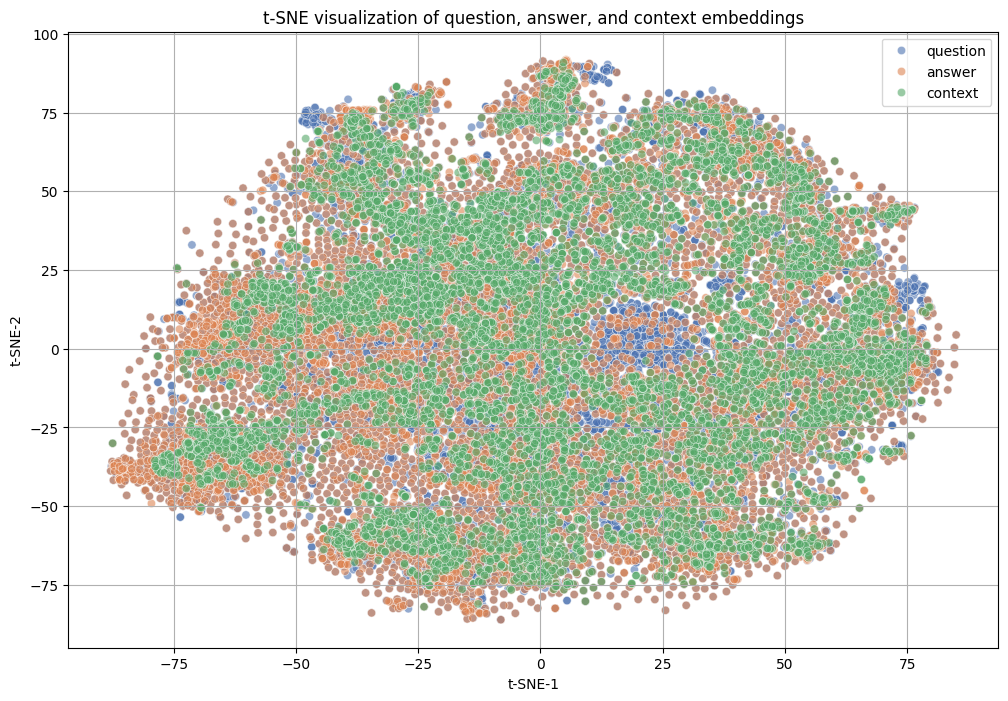

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='deep', alpha=0.6)
plt.title("t-SNE visualization of question, answer, and context embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend()
plt.grid(True)
plt.show()

All three types occupy the same semantic space.There is no hard separation between questions, answers, and contexts.

Contexts (green) dominate and spread densely.This is typical because:
 - Contexts are longer and more information-rich.
 - Their embeddings (average of more tokens) are less noisy, leading to dense clustering.

Questions (blue) are more scattered and sparse.This suggests that answers tend to be semantically close to their contexts.

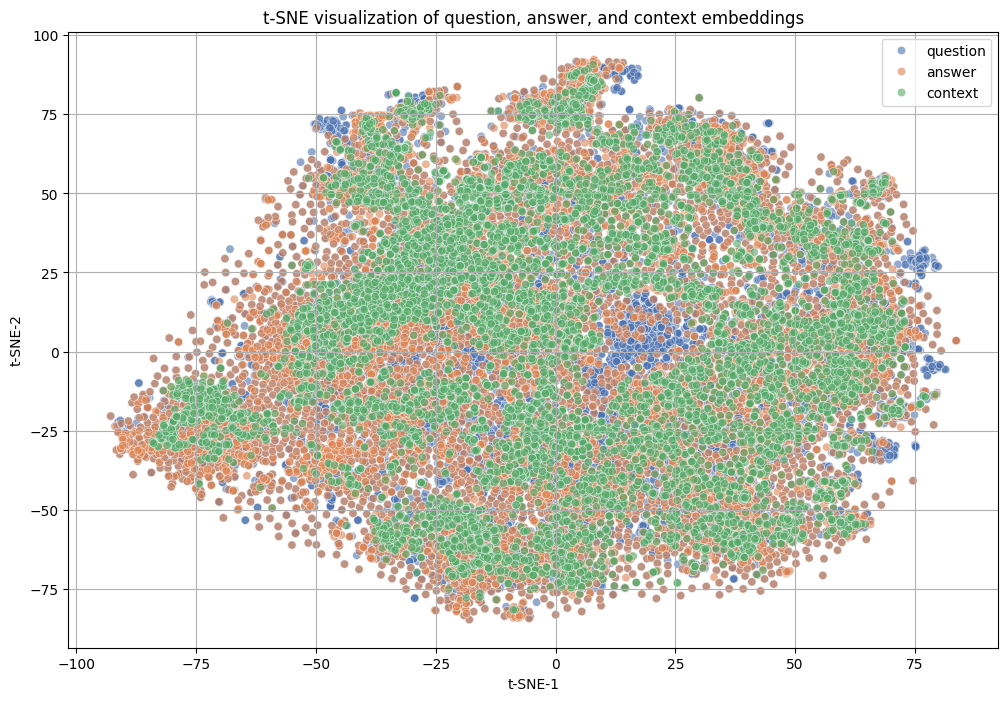

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_tsne_t[:, 0], y=X_tsne_t[:, 1], hue=labels, palette='deep', alpha=0.6)
plt.title("t-SNE visualization of question, answer, and context embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend()
plt.grid(True)
plt.show()

Same patterns were observed for tagged model as well with minor differences.

In [212]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_sim(a, b):
    return cosine_similarity([a], [b])[0][0]

In [ ]:
df['q_a_sim'] = df.apply(lambda row: cosine_sim(row['question_vec'], row['answer_vec']), axis=1)
df['q_c_sim'] = df.apply(lambda row: cosine_sim(row['question_vec'], row['context_vec']), axis=1)
df['a_c_sim'] = df.apply(lambda row: cosine_sim(row['answer_vec'], row['context_vec']), axis=1)

In [213]:
df_t['q_a_sim'] = df_t.apply(lambda row: cosine_sim(row['question_vec'], row['answer_vec']), axis=1)
df_t['q_c_sim'] = df_t.apply(lambda row: cosine_sim(row['question_vec'], row['context_vec']), axis=1)
df_t['a_c_sim'] = df_t.apply(lambda row: cosine_sim(row['answer_vec'], row['context_vec']), axis=1)

## 6. K-Means Clustering on Untagged Data

To group semantically similar text entries, we apply **K-Means clustering** on the sample-level embeddings computed from the original dataset (`df_1 → df`, without POS tagging).

Each sample (context, question, or answer) is represented by the average of its word vectors, as described previously:

$$
\vec{v}_T = \frac{1}{n} \sum_{i=1}^{n} \vec{v}_{w_i}
$$

### K-Means Overview:
K-Means aims to partition \( N \) samples into \( K \) clusters by minimizing the intra-cluster variance:

$$
\underset{C}{\text{argmin}} \sum_{k=1}^{K} \sum_{\vec{x}_i \in C_k} \| \vec{x}_i - \vec{\mu}_k \|^2
$$

Where:
- \( $C_k$ \)  is the set of samples in cluster $k$ 
- $\vec{\mu}_k$  is the centroid of cluster $k$

We apply K-Means on the untagged sample embeddings and analyze the resulting cluster assignments.


In [174]:
from sklearn.cluster import KMeans

In [175]:
X = np.stack(df['question_vec'].values)
kmeans = KMeans(n_clusters=5, random_state=42)
df['question_cluster'] = kmeans.fit_predict(X)

In [ ]:

for i in range(5):
    print(f"\n--- Cluster {i} ---")
    print(df[df['question_cluster'] == i]['question'].head(3).tolist())


--- Cluster 0 ---
[['berry', 'export', 'summary', 'purpose'], ['main', 'difference', 'national', 'sample', 'survey', 'nss', 'india', 'human', 'development', 'survey', 'ihds', 'terms', 'measuring', 'india', 'inequality'], ['cost', 'credit', 'union', 'attendees', 'assets', 'attend', 'conference']]

--- Cluster 1 ---
[['reason', 'closure', 'comments', 'section'], ['love', 'relationship', 'podcasts', 'mentioned', 'context'], ['word', 'quantum', 'mean', 'per', 'context']]

--- Cluster 2 ---
[['unique', 'features', 'coolands', 'twitter', 'app'], ['features', 'fabiana', 'filippi', 'shirts', 'blouses'], ['purpose', 'truglo', 'picatinny', 'riser', 'mount']]

--- Cluster 3 ---
[['gunnar', 'nelson', 'win', 'fight', 'zak', 'cummings', 'ufc', 'fight', 'night'], ['dan', 'foley', 'feel', 'portrayal', 'survivor', 'tv', 'show'], ['lunch', 'kim', 'tony', 'plan', 'monday', 'according', 'context']]

--- Cluster 4 ---
[['benefits', 'reported', 'access', 'self', 'supply', 'water', 'sources'], ['names', 'mo

In [178]:
X_ans = np.stack(df['answer_vec'].values)
kmeans_ans = KMeans(n_clusters=5, random_state=42)
df['answer_cluster'] = kmeans_ans.fit_predict(X_ans)

In [179]:
X_ctx = np.stack(df['context_vec'].values)
kmeans_ctx = KMeans(n_clusters=5, random_state=42)
df['context_cluster'] = kmeans_ctx.fit_predict(X_ctx)

In [180]:
print("Question Clusters:\n", df['question_cluster'].value_counts())
print("\nAnswer Clusters:\n", df['answer_cluster'].value_counts())
print("\nContext Clusters:\n", df['context_cluster'].value_counts())


Question Clusters:
 question_cluster
3    2805
0    2409
2    1747
1    1439
4    1198
Name: count, dtype: int64

Answer Clusters:
 answer_cluster
0    2227
1    2165
2    2163
4    1578
3    1465
Name: count, dtype: int64

Context Clusters:
 context_cluster
0    2790
3    2213
1    1840
4    1760
2     995
Name: count, dtype: int64


### Clustering Summary

We applied **K-Means clustering** independently on the averaged embeddings of the `context`, `question`, and `answer` columns.

Each field was clustered into 5 groups ($k = 5$), and the resulting cluster distributions are:

In the following steps, we will **analyze the contents** of each cluster to interpret what characterizes the groups — such as topic, tone, or structure.


### t-SNE Visualization with K-Means Cluster Labels

To better interpret the clusters formed by K-Means, we apply **t-SNE** to reduce the sample embeddings to 2D space and color the points by their **cluster labels**.

In [181]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded =tsne.fit_transform(X)

#### Clustering question embedings

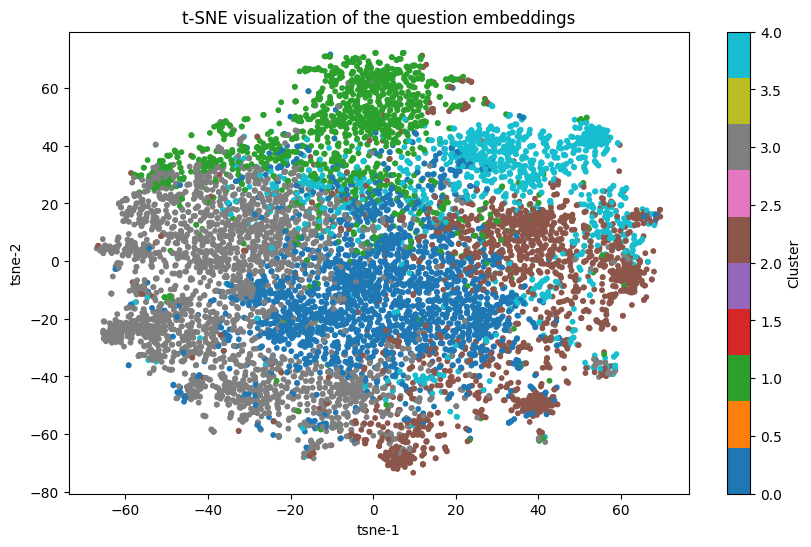

In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df['question_cluster'], cmap='tab10', s=10)
plt.title("t-SNE visualization of the question embeddings")
plt.xlabel("tsne-1")
plt.ylabel("tsne-2")
plt.colorbar(label='Cluster')
plt.show()

In the t-SNE visualization of the **question embeddings**, we observe that **Cluster 2** is noticeably more **sparse** and **dispersed** compared to other clusters.Let's go deeper on this.

In [191]:
cluster_2_questions = df[df['question_cluster'] == 2]['question']
cluster_2_questions.sample(10, random_state=42).tolist()

[['main', 'function', 'audio', 'waterproof', 'housing', 'ipod', 'shuffle'],
 ['change',
  'user',
  'suggest',
  'improve',
  'usability',
  'component',
  'visibility',
  'sub',
  'menu',
  'vmcs'],
 ['methods', 'automated', 'backup', 'systems', 'computer', 'files'],
 ['fuel', 'economy', 'infiniti', 'litre', 'petrol', 'engine'],
 ['purpose', 'microsoft', 'visual', 'studio', 'net'],
 ['ceo', 'ca', 'inc'],
 ['options',
  'consumers',
  'looking',
  'best',
  'budget',
  'cpus',
  'according',
  'discussion'],
 ['reason', 'speaker', 'buy', 'sets', 'major', 'retailers', 'anymore'],
 ['products', 'author', 'bought', 'november'],
 ['benefits', 'connecting', 'asus', 'padfone', 'docking', 'station']]

| Sample | Question Summary                                    |
| ------ | --------------------------------------------------- |
| 1      | Functional features of waterproof iPod accessories  |
| 2      | UI improvement suggestions for a software component |
| 3      | Methods for automated file backup                   |
| 4      | Fuel economy of a specific car engine               |
| 5      | Purpose of Microsoft Visual Studio                  |
| 6      | Identity of a company's CEO                         |
| 7      | Best budget CPUs for consumers                      |
| 8      | Why speakers aren't sold by big retailers anymore   |
| 9      | Products purchased by a specific author in November |
| 10     | Benefits of using Asus docking station              |


These are all very specific, often technical or product-oriented questions.They span different domains: hardware, software, companies, automotive, personal tech.

In [184]:
df['question_length'] = df['question'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df[df['question_cluster'] == 2]['question_length'].describe()

count    1747.000000
mean        6.290784
std         2.172709
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        20.000000
Name: question_length, dtype: float64

In [192]:
cluster_1_questions = df[df['question_cluster'] == 1]['question']
cluster_1_questions.sample(10, random_state=42).tolist()

[['difference',
  'legalization',
  'interracial',
  'marriage',
  'gay',
  'marriage',
  'according',
  'context'],
 ['process', 'credit', 'relief', 'described', 'context'],
 ['purpose', 'vpn', 'packets', 'context', 'industry'],
 ['steps', 'prepare', 'dish', 'mentioned', 'context'],
 ['method',
  'mentioned',
  'context',
  'used',
  'prove',
  'user',
  'robot',
  'buying',
  'stuff',
  'online'],
 ['main', 'focus', 'cpe', 'course', 'mentioned', 'context'],
 ['method',
  'person',
  'adopt',
  'improve',
  'track',
  'record',
  'following',
  'holy',
  'spirit',
  'tells'],
 ['essential', 'dating', 'tips', 'men', 'mentioned', 'context'],
 ['main', 'focus', 'carrie', 'fisher', 'account', 'book', 'shockaholic'],
 ['word',
  'tzedakah',
  'mean',
  'context',
  'rabbi',
  'ephraim',
  'z',
  'buchwald',
  'teachings']]

Semantic Features of Cluster 1

🔹 1. High frequency of the word “context”
Almost every question includes "context" or "mentioned in context".
This suggests these are context-aware comprehension or reading comprehension style questions.

🔹 2. Templated structure
Many follow the form:

"What is the [$X$] mentioned in the context?"

"What does [$term$] mean in context?"

"What is the main purpose/focus of [$entity$]?"

In [194]:
cluster_0_questions = df[df['question_cluster'] == 0]['question']
cluster_0_questions.sample(10, random_state=42).tolist()

[['purpose',
  'deployment',
  'missile',
  'system',
  'bastion',
  'southern',
  'kuril',
  'islands',
  'according',
  'russian',
  'foreign',
  'ministry',
  'spokeswoman',
  'maria',
  'zakharova'],
 ['main', 'roles', 'volunteers', 'runday', 'running', 'movement'],
 ['benefits', 'volunteering', 'shugborough'],
 ['total', 'sales', 'national', 'lottery', 'financial', 'year'],
 ['key', 'principles', 'tai', 'chi', 'martial', 'art'],
 ['expected', 'performance', 'asx', 'start', 'week'],
 ['role',
  'senior',
  'devops',
  'engineer',
  'fintech',
  'company',
  'central',
  'london'],
 ['plans', 'enrique', 'peña', 'nieto', 'combat', 'drug', 'gangs', 'mexico'],
 ['primary', 'areas', 'machine', 'learning', 'play', 'important', 'role'],
 ['purpose',
  'american',
  'logistics',
  'aid',
  'network',
  'alan',
  'operate',
  'disaster']]

Features of CLuster 0: 

1. Straightforward factual questions
Most queries are asking for definitions, differences, roles, or explanations:

“What is the purpose of ___?”

“What is the cost/role/main difference of ___?”

2. Frequently used "utility" words:
plaintext
Копировать
Редактировать
"features", "purpose", "services", "offered", "benefits", "types", "used", "main", "system", "user"
These are highly generic nouns or verbs that appear in utility-style informational queries.

In [195]:
cluster_4_questions = df[df['question_cluster'] == 4]['question']
cluster_4_questions.sample(10, random_state=42).tolist()

[['things', 'need', 'know', 'leave', 'buy', 'car'],
 ['lifestyle',
  'changes',
  'help',
  'slow',
  'process',
  'heart',
  'disease',
  'age'],
 ['author', 'decide', 'use', 'office', 'nursery', 'baby'],
 ['color', 'range', 'labradorite', 'stone', 'described', 'bracelet'],
 ['toys', 'suitable', 'infants', 'aged', 'months'],
 ['picosure', 'laser', 'used', 'skin', 'rejuvenation'],
 ['family',
  'plants',
  'focus',
  'search',
  'natural',
  'products',
  'activity',
  'major',
  'protozoan',
  'pathogens',
  'responsible',
  'human',
  'diseases'],
 ['steps', 'suggested', 'making', 'money', 'long', 'haul', 'stock', 'market'],
 ['process',
  'preparing',
  'meal',
  'using',
  'slow',
  'cooker',
  'according',
  'context'],
 ['common',
  'types',
  'car',
  'bike',
  'collisions',
  'according',
  'david',
  'crowe']]

Cluster 4 represents real-world, practical life queries — focused on health, parenting, finance, cooking, consumer products, and routines.

In [196]:
cluster_3_questions = df[df['question_cluster'] == 3]['question']
cluster_3_questions.sample(10, random_state=42).tolist()

[['hosted', 'clean', 'slate', 'read', 'thon'],
 ['founder', 'beaver', 'creek', 'soap', 'co'],
 ['scored',
  'game',
  'winning',
  'goal',
  'ice',
  'hockey',
  'match',
  'quinnipiac',
  'university',
  'dartmouth'],
 ['many', 'times', 'grayshott', 'hampshire', 'village', 'year', 'award'],
 ['distinguished',
  'conduct',
  'medal',
  'dcm',
  'replaced',
  'conspicuous',
  'gallantry',
  'cross'],
 ['decided', 'retire', 'florida', 'state', 'coach'],
 ['heather', 'divas', 'run', 'bling'],
 ['win', 'collection', 'pack', 'fancy', 'pants', 'blissful', 'blizzard'],
 ['central', 'figures', 'novel', 'tiger', 'hills'],
 ['rumored', 'direct', 'next', 'installment', 'avengers', 'infinity', 'war']]

Cluster 3 groups factoid-style, news/event/trivia-based questions involving proper nouns and named entities.
These questions likely stem from:
 - Current events

 - Media content

 - Sports

 - Biographies

 - Awards & pop culture

#### Combined Clustering of Context, Question, and Answer

To explore whether semantic patterns are preserved across different fields, we **combined the embeddings of `context`, `question`, and `answer`** for each sample into a single unified representation.


In [200]:
df_q = pd.DataFrame(df['question_vec'].tolist())
df_q['type'] = 'question'
df_a = pd.DataFrame(df['answer_vec'].tolist())
df_a['type'] = 'answer'
df_c = pd.DataFrame(df['context_vec'].tolist())
df_c['type'] = 'context'
# объединяем
df_all = pd.concat([df_q, df_a, df_c], ignore_index=True)

In [201]:
X_all = df_all.drop(columns=['type']).values  
tsne_all = TSNE(n_components=2, random_state=42, perplexity=50)
X_2d = tsne_all.fit_transform(X_all)

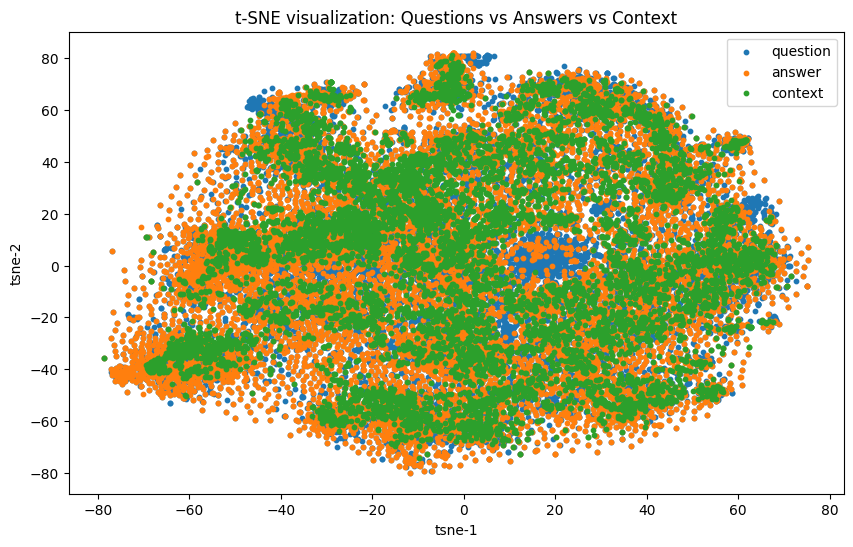

In [202]:
df_all['tsne-1'] = X_2d[:, 0]
df_all['tsne-2'] = X_2d[:, 1]

plt.figure(figsize=(10, 6))

for label in df_all['type'].unique():
    subset = df_all[df_all['type'] == label]
    plt.scatter(subset['tsne-1'], subset['tsne-2'], label=label, s=10)

plt.legend()
plt.title("t-SNE visualization: Questions vs Answers vs Context")
plt.xlabel("tsne-1")
plt.ylabel("tsne-2")
plt.show()

Answers and contexts often share similar semantic features. This means answers are frequently extracted or closely related to the context in QA datasets.

Questions are more sparse meaning that they are semantically distinct.Their phrasing may vary more (e.g., interrogatives, syntax differences). Potentially higher lexical variance than answer/context

## 7. K-Means Clustering on POS-Tagged Data

We now apply **K-Means clustering** on the embeddings generated from the **POS-tagged** dataset (`df_tagged → df`).  
Unlike the previous setup, here each word includes its part-of-speech label (e.g., `regulation_NN`, `like_VB`), allowing the model to distinguish between different grammatical roles of the same word.

### Objective:
To evaluate whether syntactic information captured via POS tags improves semantic grouping in the clustering step.


In [216]:
X_t = np.stack(df_t['context_vec'].values)
kmeans_t = KMeans(n_clusters=5, random_state=42)
df_t['context_cluster'] = kmeans_t.fit_predict(X_t)
for i in range(5):
    print(f"\n--- Cluster {i} ---")
    print(df_t[df_t['context_cluster'] == i]['context'].head(3).tolist())


--- Cluster 0 ---
[['gunnar_NN', 'nelson_NN', 'took_VBD', 'time_NN', 'feet_NNS', 'zak_JJ', 'cummings_NNS', 'tonight_VBD', 'co_NN', 'main_JJ', 'event_NN', 'ufc_JJ', 'fight_NN', 'night_NN', 'finally_RB', 'saw_VBD', 'opportunity_NN', 'switch_NN', 'gears_NNS', 'second_JJ', 'round_NN', 'pounced_VBD', 'taking_VBG', 'opponent_JJ', 'mat_NN', 'seizing_VBG', 'back_RP', 'locking_VBG', 'fight_NN', 'ending_VBG', 'choke_VBD', 'almost_RB', 'effortlessly_RB', 'round_JJ', 'nelson_RB', 'usual_JJ', 'karate_NN', 'style_NN', 'stance_NN', 'keeps_VBZ', 'range_JJ', 'cummings_NNS', 'early_JJ', 'strikes_NNS', 'presses_NNS', 'clinch_JJ', 'cummings_NNS', 'matches_NNS', 'jockey_JJ', 'position_NN', 'break_IN', 'apart_JJ', 'nelson_JJ', 'lands_NNS', 'good_JJ', 'knee_NN', 'nelson_NN', 'lands_VBZ', 'right_JJ', 'hook_NN', 'misses_NNS', 'overhand_VBP', 'nelson_JJ', 'relaxed_JJ', 'alert_NN', 'continually_RB', 'makes_VBZ', 'cumming_VBG', 'miss_JJ', 'backing_NN', 'enough_RB', 'right_JJ', 'hand_NN', 'counter_NN', 'lands_VBZ

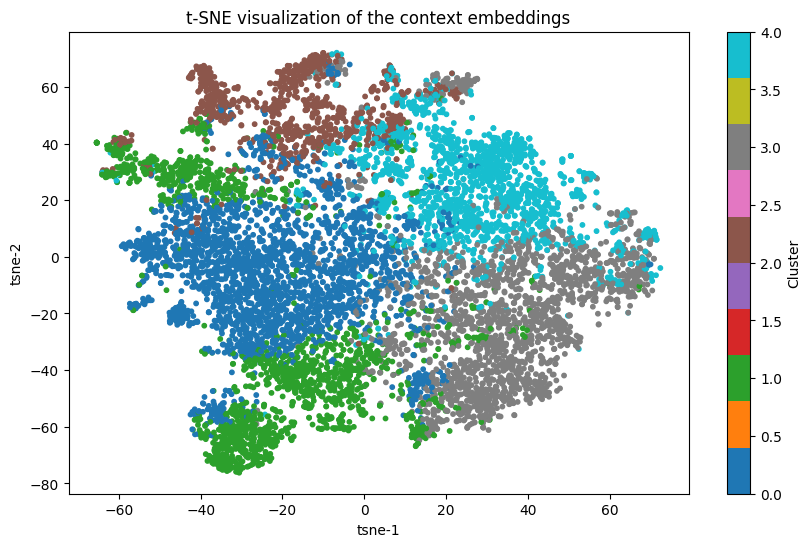

In [217]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded =tsne.fit_transform(X_t)
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df['context_cluster'], cmap='tab10', s=10)
plt.title("t-SNE visualization of the context embeddings")
plt.xlabel("tsne-1")
plt.ylabel("tsne-2")
plt.colorbar(label='Cluster')
plt.show()

### Comparison: Tagged vs Untagged Clustering

Clustering results using **POS-tagged data** are broadly similar to those from the **untagged** data, with only minor differences in cluster structure and distribution.

### Key Observations:
- The overall **number and balance of clusters** remains stable between the two settings.
- POS tagging introduces **slight improvements** in grouping syntactically similar samples, particularly in disambiguating words like "run" (verb vs noun) or "like" (verb vs preposition).
- Some clusters appear **marginally tighter** or **more coherent** in the tagged setup, especially for question and answer texts.

### Conclusion:
While POS tagging does not drastically change clustering outcomes, it adds useful syntactic granularity that may benefit **interpretability** and **downstream analysis**, especially in more linguistically diverse corpora.


## 8. Cosine Similarity Analysis

To quantitatively assess the **semantic alignment** between the fields (`context`, `question`, and `answer`), we compute **cosine similarity** between their vector embeddings.

Cosine similarity measures the **angle** between two vectors in the embedding space, providing a normalized score of their directional alignment.

### Formula:

Given two vectors , the cosine similarity is defined as:

$$
\text{cosine\_sim}(\vec{a}, \vec{b}) = \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\| \, \|\vec{b}\|}
$$


### Purpose:
- Identify how closely related each pair of text fields is, semantically
- Detect samples with **strong alignment** (e.g., context and answer are tightly connected)
- Spot **inconsistencies or noise**, where cosine similarity is low


In [224]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Ensure vectors are numpy arrays
df['q_a_sim'] = df.apply(lambda row: cosine_similarity(
    [row['question_vec']], [row['answer_vec']])[0][0], axis=1)

df['q_c_sim'] = df.apply(lambda row: cosine_similarity(
    [row['question_vec']], [row['context_vec']])[0][0], axis=1)

df['a_c_sim'] = df.apply(lambda row: cosine_similarity(
    [row['answer_vec']], [row['context_vec']])[0][0], axis=1)


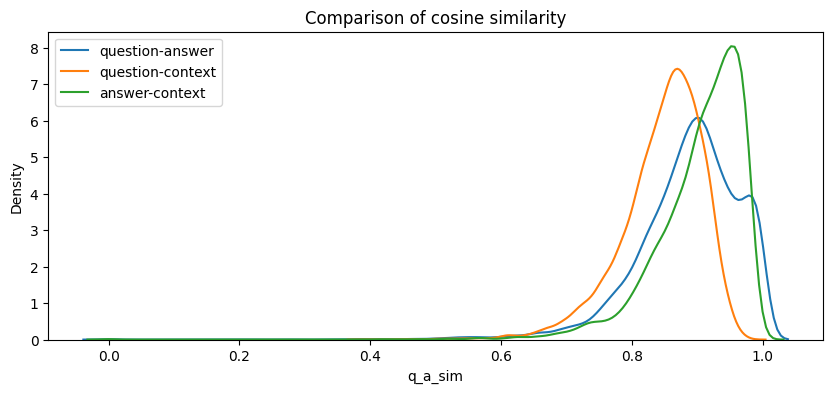

In [225]:
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.kdeplot(df['q_a_sim'], label='question-answer')
sns.kdeplot(df['q_c_sim'], label='question-context')
sns.kdeplot(df['a_c_sim'], label='answer-context')
plt.legend()
plt.title("Comparison of cosine similarity")
plt.show()

### Cosine Similarity Insights

The distribution of cosine similarity scores revealed meaningful semantic relationships among the text fields:

- **Answers are more similar to the context** than questions are, indicating that answers are typically well-aligned with the source information.
- **Questions show the lowest similarity to answers**, which suggests that answers are **not simply rephrasings**, but instead reflect **deeper reasoning** or **inference** based on the context.

### Interpretation:
These findings support the idea that:
- **Questions abstract away** from the raw context, often focusing on a specific subtopic or fact.
- **Answers are derived** more directly from the context, incorporating key terms and phrasing found in it.

This reinforces the value of context-aware models that can bridge the semantic gap between questions and answers.


---
# 📘 Summarization Model with LoRA and PEFT using FLAN-T5

### 🔍 Objective:
The goal of this notebook is to build a lightweight, instruction-following **summarization model** that generates concise answers from a given **question + context** input.

We fine-tune the **FLAN-T5** model using a **parameter-efficient method** (PEFT) called **LoRA (Low-Rank Adaptation)**. The dataset consists of context-question-answer triples, where the answer serves as a summary of the context in response to the question.

---

### 🛠️ Approach Summary:
- **Model**: `google/flan-t5-base` (pretrained on instruction-following tasks)
- **Task framing**: Instruction-based summarization using `"summarize: "` prefix
- **Data**: `neural-bridge/rag-dataset-12000` (QA-style summarization)
- **Fine-tuning**: We apply **LoRA adapters** to inject trainable parameters without updating the full model
- **Training Framework**: `adapter-transformers` + HuggingFace Trainer

---

### 🧠 What is LoRA?

**LoRA (Low-Rank Adaptation)** is a technique for fine-tuning large language models by **inserting trainable rank-decomposed matrices** into each layer, while **keeping the original weights frozen**.

Instead of updating the full weight matrix $W \in \mathbb{R}^{d \times d}$ , LoRA approximates the update as:

$$
\Delta W \approx A B \quad \text{where } A \in \mathbb{R}^{d \times r}, \; B \in \mathbb{R}^{r \times d}, \; r \ll d
$$

This drastically reduces the number of trainable parameters and allows efficient adaptation with less compute and memory.

---

### 🧩 What is PEFT?

**PEFT (Parameter-Efficient Fine-Tuning)** refers to any technique that fine-tunes only a **subset of a model's parameters**.  
LoRA is one such method under this umbrella, making it possible to:
- Reuse the same base model across tasks
- Add/remove adapters without retraining
- Reduce storage and deployment cost

---

### ⚡ Why This Setup?

Fine-tuning large models like FLAN-T5 from scratch is expensive and often unnecessary.  
LoRA + PEFT lets us train compact and effective models even on modest hardware, making this setup ideal for:
- Domain adaptation
- Instruction tuning
- Fast experimentation

## 1. Load Tokenizer

We load the tokenizer for the FLAN-T5 base model.  
This tokenizer will be used for encoding inputs (question + context) and decoding model outputs (answers).

In [1]:
from transformers import AutoTokenizer

base_model = "google/flan-t5-base"

tokenizer = AutoTokenizer.from_pretrained(base_model)
prefix = 'summarize: '

## 2. Define Tokenization Function

This function encodes a batch of data:
- Inputs are created by concatenating `question` + `context`, prefixed with `"summarize: "`.
- Targets are the `answer` texts.
- Both are tokenized with truncation and padding.
- The result is returned as a dictionary with `input_ids` and `labels`.


In [2]:
def encode_batch(examples):
    text_column1 = 'context'
    text_column2 = 'question'
    summary_column = 'answer'
    
    padding = "max_length"

    inputs, targets = [], []
    for i in range(len(examples[text_column1])):
        if examples[text_column1][i] and examples[text_column2][i] and examples[summary_column][i]:
            # Concatenate question + context
            input_text = examples[text_column2][i] + " " + examples[text_column1][i]
            inputs.append(input_text)
            targets.append(examples[summary_column][i])


    inputs = [prefix + inp for inp in inputs]

    model_inputs = tokenizer(inputs, max_length=512, padding=padding, truncation=True)
    labels = tokenizer(targets, max_length=128, padding=padding, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

## 3. Load and Prepare Dataset

This function loads the dataset split (`train` or `test`) and:
- Filters out rows with missing `context` or `answer`
- Limits the number of rows to `max_items`
- Applies tokenization using `encode_batch`
- Formats the dataset as PyTorch tensors for training


In [3]:
def load_split(split_name, max_items):
    
    dataset = load_dataset("neural-bridge/rag-dataset-12000")[split_name] 


    dataset = dataset.filter(lambda example: example['context'] is not None and example['answer'] is not None)
    
    dataset = dataset.filter(lambda _, idx: idx < max_items, with_indices=True)
    
    
    dataset = dataset.map(
        encode_batch,
        batched=True,
        remove_columns=dataset.column_names,
        desc="Running tokenizer on " + split_name + " dataset",
    )
    
    dataset.set_format(type="torch", columns=["input_ids", "labels"])

    return dataset

## 4. Load Model and Add LoRA Adapter

We use the AdapterHub-compatible model (`AutoAdapterModel`) and apply **LoRA (Low-Rank Adaptation)**:
- `r = 8`: Low-rank dimensionality
- `alpha = 16`: Scaling factor
- `intermediate_lora` and `output_lora`: Apply LoRA to both FFN and output layers

This enables **parameter-efficient fine-tuning** without updating the entire base model.


In [4]:
#from transformers import AutoModelForSeq2SeqLM
from adapters import LoRAConfig

from adapters import AutoAdapterModel

model = AutoAdapterModel.from_pretrained(base_model)

# Load the model
#model = AutoModelForSeq2SeqLM.from_pretrained(base_model)

config = LoRAConfig(
    r=8,
    alpha=16,
    intermediate_lora=True,
    output_lora=True
)


In [5]:
print(type(model))

<class 'adapters.models.t5.adapter_model.T5AdapterModel'>


In [7]:
#model.add_adapter("my_summary_adapter", config=config, adapter_type="lora")
model.add_adapter(adapter_name="my_summary_adapter", config=config)

model.train_adapter("my_summary_adapter")
model.set_active_adapters("my_summary_adapter")

## 5. Define Training Configuration and Start Training

We configure the trainer using HuggingFace's `TrainingArguments`:
- 2 epochs
- Batch size of 2
- Logging every 50 steps

We use `AdapterTrainer` to train only the adapter layer, leaving the base model frozen.

Training and evaluation are performed on subsets of 1,000 training and 100 test examples.


In [8]:
from transformers import TrainingArguments
from adapters import AdapterTrainer
from datasets import load_dataset
batch_size = 2  

training_args = TrainingArguments(
    learning_rate=3e-4,
    num_train_epochs=2,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_steps=50,
    output_dir="./training_output",
    overwrite_output_dir=True,
    remove_unused_columns=False,
)

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=load_split("train", 1000),
    eval_dataset=load_split("test", 100),
)

trainer.train()


Running tokenizer on train dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Running tokenizer on test dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
50,23.355300
100,5.437000
150,2.837900
200,1.171000
250,0.583200
300,0.565700
350,0.546600
400,0.631200
450,0.528300
500,0.455200


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


TrainOutput(global_step=1000, training_loss=2.037519121170044, metrics={'train_runtime': 387.6525, 'train_samples_per_second': 5.159, 'train_steps_per_second': 2.58, 'total_flos': 1381594300416000.0, 'train_loss': 2.037519121170044, 'epoch': 2.0})

In [9]:
trainer.evaluate()

{'eval_loss': 0.38506218791007996,
 'eval_runtime': 6.0071,
 'eval_samples_per_second': 16.647,
 'eval_steps_per_second': 8.324,
 'epoch': 2.0}

## 6. Merge Adapter with Base Model

After training, the adapter is merged into the base model so it can be used for standalone inference without adapter activation.

In [ ]:
model.merge_adapter("my_summary_adapter")

## 7. Run Inference

We test the trained summarization model by passing in a question and a long context.  
The model generates a summary using its learned instruction-following ability.

#### Output:
> **Generated Summary**:  
> *The story of the magic mill spread far and wide.*

This shows the model's ability to extract and compress key information into a brief, high-level summary.


In [11]:
context = """
Once upon a time, there were two brothers — one was rich, and the other was poor. The poor brother ran out of food and went to his rich brother, begging for something to eat.

The rich brother, not happy about helping, said, “I’ll give you this ham, but you must take it to Dead Man’s Hall.”

Grateful for the food, the poor brother agreed. He walked all day and finally reached a large building at dusk. Outside, an old man was chopping wood.

“Excuse me, sir,” said the poor brother. “Is this the way to Dead Man’s Hall?”

“Yes, you’ve arrived,” replied the old man. “Inside, they will want to buy your ham. But don’t sell it unless they give you the hand-mill that stands behind the door.”

The poor brother thanked the old man, went inside, and everything happened just as the old man had said. The poor brother left with the hand-mill and asked the old man how to use it. Then, he set off home.

The hand-mill was magical. When the poor brother got home, he asked it to grind a feast of food and drink. To stop the mill, he simply had to say, “Thank you, magic mill, you can stop now.”

When the rich brother saw that his brother was no longer poor, he became jealous. “Give me that mill!” he demanded. The poor brother, having everything he needed, agreed to sell it but didn’t tell his rich brother how to stop it.

The rich brother eagerly asked the mill to grind food when he got home, but because he didn’t know how to stop it, the mill kept grinding until food overflowed from the house and across the fields. In a panic, he ran to his poor brother’s house. “Please take it back!” he cried. “If it doesn’t stop, the whole town will be buried!”

The poor brother took the mill back and was never poor or hungry again.

Soon, the story of the magic mill spread far and wide. One day, a sailor knocked at the poor brother’s door. “Does the mill grind salt?” he asked.

“Of course,” replied the brother. “It will grind anything you ask.”

The sailor, eager to stop traveling far for salt, offered a thousand coins for the mill. Though the brother was hesitant, he eventually agreed.

In his hurry, the sailor forgot to ask how to stop the mill. Once at sea, he placed the mill on deck and commanded, “Grind salt, and grind quickly!”

The mill obeyed, but it didn’t stop. The pile of salt grew and grew until the ship sank under its weight.

The mill still lies at the bottom of the sea, grinding salt to this day, and that’s why the sea is salty.

"""
question = "Summarize the story."

input_text = prefix + question + " " + context

inputs = tokenizer(input_text, return_tensors="pt", truncation=True).to(model.device)

output = model.generate(**inputs, max_length=128)

generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
print("Input:\n", input_text)
print("\nGenerated Summary:\n", generated_summary)


Input:
 summarize: Summarize the story. 
Once upon a time, there were two brothers — one was rich, and the other was poor. The poor brother ran out of food and went to his rich brother, begging for something to eat.

The rich brother, not happy about helping, said, “I’ll give you this ham, but you must take it to Dead Man’s Hall.”

Grateful for the food, the poor brother agreed. He walked all day and finally reached a large building at dusk. Outside, an old man was chopping wood.

“Excuse me, sir,” said the poor brother. “Is this the way to Dead Man’s Hall?”

“Yes, you’ve arrived,” replied the old man. “Inside, they will want to buy your ham. But don’t sell it unless they give you the hand-mill that stands behind the door.”

The poor brother thanked the old man, went inside, and everything happened just as the old man had said. The poor brother left with the hand-mill and asked the old man how to use it. Then, he set off home.

The hand-mill was magical. When the poor brother got home,